## **Importing Libraries**

In [6]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras.models import Model
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import random
import os

## **Data Preprocessing**

In [7]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [8]:
%cd /content/drive/MyDrive/MultiClassClassification

train_data_dir = "/content/drive/MyDrive/MultiClassClassification/cropped_months/train/"
test_data_dir = "/content/drive/MyDrive/MultiClassClassification/cropped_months/test/"
class_subset = sorted(os.listdir(train_data_dir))[:12]

#training data
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(263, 173),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)
#validation data
validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(263, 173),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)
#testing data
testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(263, 173),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

/content/drive/MyDrive/MultiClassClassification
Found 5100 images belonging to 12 classes.
Found 900 images belonging to 12 classes.
Found 1440 images belonging to 12 classes.


## **Hyper Parameters**

In [9]:
epochs=50
adm = Adam(learning_rate=0.0001)
n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE

## **Model Building**

In [10]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [11]:

# ModelCheckpoint callback - save best weights
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/MultiClassClassification/checkpoints/tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

## **Compiling and Training**

In [12]:



# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
model_vgg16 = create_model((263,173,3), 12, adm, fine_tune=2)


#Training VGG16
vgg_history=model_vgg16.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[model_checkpoint, early_stop],
                            verbose=1)


Epoch 1/50
159/159 [==============================] - 126s 721ms/step - loss: 2.3947 - accuracy: 0.2614 - val_loss: 1.6691 - val_accuracy: 0.4007

Epoch 00001: val_loss improved from inf to 1.66907, saving model to /content/drive/MyDrive/MultiClassClassification/checkpoints/tl_model_v1.weights.best.hdf5
Epoch 2/50
159/159 [==============================] - 114s 714ms/step - loss: 1.5563 - accuracy: 0.4491 - val_loss: 1.3194 - val_accuracy: 0.5190

Epoch 00002: val_loss improved from 1.66907 to 1.31943, saving model to /content/drive/MyDrive/MultiClassClassification/checkpoints/tl_model_v1.weights.best.hdf5
Epoch 3/50
159/159 [==============================] - 108s 681ms/step - loss: 1.3073 - accuracy: 0.5401 - val_loss: 1.1564 - val_accuracy: 0.5993

Epoch 00003: val_loss improved from 1.31943 to 1.15642, saving model to /content/drive/MyDrive/MultiClassClassification/checkpoints/tl_model_v1.weights.best.hdf5
Epoch 4/50
159/159 [==============================] - 111s 700ms/step - loss:

## **Accuracy**

In [ ]:
model_vgg16.load_weights('/content/drive/MyDrive/MultiClassClassification/checkpoints/tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model_vgg16.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)


In [17]:
print("VGG16 Model Accuracy: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy: 88.68%


## **Confusion Matrix**

In [21]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

Confusion matrix, without normalization


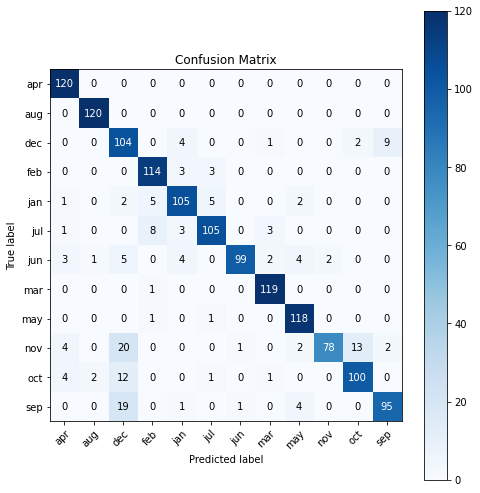

In [25]:
# Get the names of the ten classes
class_names = testgen.class_indices.keys()
#Plotting non-normalized confusion matrix
plot_confusion_matrix(true_classes, vgg_pred_classes, classes = class_names,  title = 'Confusion Matrix')
